In [1]:
import osmium as osm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.image as mpimg
from sklearn.cluster import DBSCAN
import numpy as np
import os
from collections import Counter
from math import radians, cos, sin, asin, sqrt

# Setze den Pfad zum Dataset
dataset_path = os.path.join("Datasets", "grossostheim.osm")
filename = os.path.basename(dataset_path)
title = filename.split('.')[0].capitalize()

### Datensatz um alle Daten auszulesen

In [2]:
class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []

    def tag_inventory(self, elem, elem_type, lon=None, lat=None, node_ids=None):
        if len(elem.tags) == 0:
            # Für Knoten ohne Tags
            self.osm_data.append([elem_type, 
                                  elem.id, 
                                  elem.visible, 
                                  0, 
                                  None, 
                                  None, 
                                  lon, 
                                  lat, 
                                  node_ids])
        else:
            for tag in elem.tags:
                self.osm_data.append([elem_type, 
                                      elem.id,
                                      elem.visible,
                                      len(elem.tags),
                                      tag.k, 
                                      tag.v, lon, lat, node_ids])

    def node(self, n):
        self.tag_inventory(n, "node", lon=n.location.lon, lat=n.location.lat)

    def way(self, w):
        node_ids = [n.ref for n in w.nodes]  
        self.tag_inventory(w, "way", node_ids=node_ids)

# Daten auslesen
osmhandler = OSMHandler()
osmhandler.apply_file(dataset_path)

# DataFrame erstellen
data_colnames = ['type', 'id', 'visible', 'ntags', 'tagkey', 'tagvalue', 'longitude', 'latitude', 'node_ids']
df_osm = pd.DataFrame(osmhandler.osm_data, columns=data_colnames)
df_osm

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
0,node,28790715,True,7,ele,137,9.07559,49.920746,None
1,node,28790715,True,7,name,Großostheim,9.07559,49.920746,None
2,node,28790715,True,7,place,town,9.07559,49.920746,None
3,node,28790715,True,7,population,8505,9.07559,49.920746,None
4,node,28790715,True,7,postal_code,63762,9.07559,49.920746,None
...,...,...,...,...,...,...,...,...,...
49366,way,1309342452,True,1,building,garage,NaN,NaN,"[1397176490, 12124398723, 12124398724, 1212439..."
49367,way,1319306009,True,4,highway,track,NaN,NaN,"[12209447859, 12209447860, 12209447861, 122094..."
49368,way,1319306009,True,4,note,vorübergehende Baustellenzufahrt?,NaN,NaN,"[12209447859, 12209447860, 12209447861, 122094..."
49369,way,1319306009,True,4,surface,fine_gravel,NaN,NaN,"[12209447859, 12209447860, 12209447861, 122094..."


### Datensatz für Straßen

In [3]:
ways_filter = df_osm[(df_osm['type'] == 'way') &
                        (df_osm['tagkey'] == 'highway')]
ways_filter

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
27556,way,7974876,True,15,highway,secondary,NaN,NaN,"[59648284, 6237482222, 3190521520]"
27562,way,7974877,True,8,highway,residential,NaN,NaN,"[1395946813, 1536953569, 10676242033, 44496937..."
27571,way,7974878,True,11,highway,residential,NaN,NaN,"[248048803, 59649381, 59649382, 59649383, 5964..."
27586,way,22568421,True,11,highway,secondary,NaN,NaN,"[4448947972, 6251639255, 279546515, 6251639256..."
27593,way,22568422,True,8,highway,secondary,NaN,NaN,"[241929831, 4448947972, 6251639254, 6251639253..."
...,...,...,...,...,...,...,...,...,...
49302,way,1237359778,True,8,highway,residential,NaN,NaN,"[9356609650, 11492522213]"
49310,way,1237359779,True,8,highway,residential,NaN,NaN,"[11492522214, 1395974861, 276204655]"
49319,way,1254165414,True,12,highway,tertiary,NaN,NaN,"[7658341037, 8208477763, 8208477760, 276203029]"
49330,way,1256617427,True,9,highway,tertiary,NaN,NaN,"[9303505682, 271469248, 4449691987, 3190572367..."


### Haversine Formel für die Längenberechnung

In [4]:
def haversine(lon1, lat1, lon2, lat2):
    # Dezimalzahlen in Radianten umwandeln
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine Formel
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius der Erde in Kilometer
    return c * r * 1000

### Straßenlänge berechnen

In [22]:
def calculate_full_road_length(way_row, df_nodes):
    node_ids = way_row['node_ids']
    total_length = 0

    for i in range(len(node_ids) - 1):
        first_node = df_nodes[df_nodes['id'] == node_ids[i]]
        second_node = df_nodes[df_nodes['id'] == node_ids[i + 1]]

        # Überprüfung, ob beide Knoten existieren
        if first_node.empty or second_node.empty:
            return None

        total_length += haversine(
            first_node['longitude'].values[0], first_node['latitude'].values[0],
            second_node['longitude'].values[0], second_node['latitude'].values[0]
        )

    return total_length

road_lengths = []

for index, way_row in ways_filter.iterrows():
    length = calculate_full_road_length(way_row, df_osm)
    if length is not None:
        road_lengths.append({'way_id': way_row['id'], 'length': length})

df_road_length = pd.DataFrame(road_lengths)

df_road_length

,way_id,length
0,7974876,38.281202
1,7974877,635.135791
2,7974878,223.802003
3,22568421,33.274912
4,22568422,28.222473
...,...,...
908,1237359778,12.831510
909,1237359779,13.022585
910,1254165414,37.014617
911,1256617427,44.816311


### Datensatz auf nur Kreuzungspunkte reduzieren

In [5]:
all_node_ids = []
for node_ids_list in ways_filter['node_ids']:
    if node_ids_list is not None:
        all_node_ids.extend(node_ids_list)

node_reference_count = Counter(all_node_ids)

nodes_referenced_multiple = {node_id for node_id, count in node_reference_count.items() if count > 1}

df_nodes_filtered_multiple = df_osm[(df_osm['type'] == 'node') & (df_osm['id'].isin(nodes_referenced_multiple))]

filtered_data_multiple = pd.concat([ways_filter, df_nodes_filtered_multiple], ignore_index=True)

filtered_data_multiple

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
0,way,7974876,True,15,highway,secondary,NaN,NaN,"[59648284, 6237482222, 3190521520]"
1,way,7974877,True,8,highway,residential,NaN,NaN,"[1395946813, 1536953569, 10676242033, 44496937..."
2,way,7974878,True,11,highway,residential,NaN,NaN,"[248048803, 59649381, 59649382, 59649383, 5964..."
3,way,22568421,True,11,highway,secondary,NaN,NaN,"[4448947972, 6251639255, 279546515, 6251639256..."
4,way,22568422,True,8,highway,secondary,NaN,NaN,"[241929831, 4448947972, 6251639254, 6251639253..."
...,...,...,...,...,...,...,...,...,...
2353,node,11486925682,True,0,None,None,9.077929,49.921546,None
2354,node,11486925686,True,0,None,None,9.078229,49.921333,None
2355,node,11492522213,True,0,None,None,9.078343,49.921610,None
2356,node,11492522214,True,0,None,None,9.076932,49.922489,None


### Graph vor dem Entfernen der Grad-2-Knoten

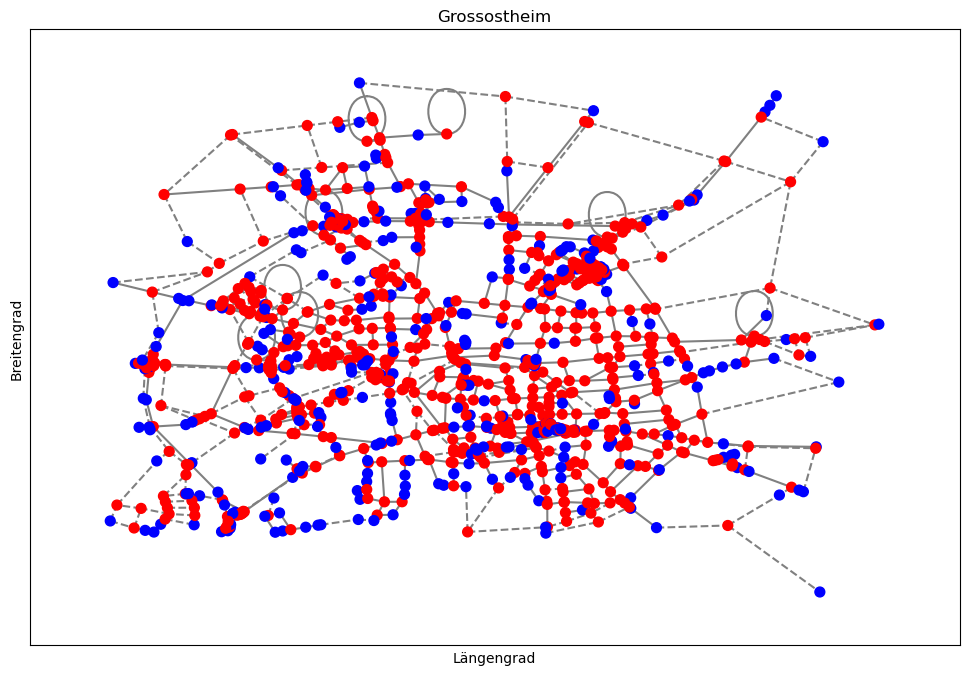

In [7]:
G = nx.Graph()

# Knoten zum Graphen hinzufügen
for index, row in filtered_data_multiple.iterrows():  
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

# Kanten zum Graphen hinzufügen
for index, way in ways_filter.iterrows():
    node_ids_list = way['node_ids']
    if node_ids_list is not None:
        filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
        if len(filtered_node_ids_list) > 1:
            for i in range(len(filtered_node_ids_list) - 1):
                is_dashed_highway = way['tagkey'] == 'highway' and way['tagvalue'] not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                G.add_edge(
                    filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                    street_name=way['tagvalue'],
                    is_dashed_highway=is_dashed_highway
                )

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(12, 8))

# Normale Kanten zeichnen
edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

# Gestrichelte Kanten zeichnen
edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

node_degrees = dict(G.degree())
node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

# Optional: Kantenbeschriftungen mit Straßennamen anzeigen
# edge_labels = nx.get_edge_attributes(G, 'street_name')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

plt.title(title)
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.show()

### Knoten vom Grad 2 entfernen

In [6]:
G = nx.Graph()

# Extrahieren der Knoten_Ids
existing_node_ids = set(filtered_data_multiple[filtered_data_multiple['type'] == 'node']['id'])

# Wege durchgehen und Kanten im Graphen hinzufügen
for _, row in ways_filter.iterrows():
    node_ids = row['node_ids']
    if node_ids is not None:
        valid_node_ids = [node_id for node_id in node_ids if node_id in existing_node_ids]
        for i in range(len(valid_node_ids) - 1):
            G.add_edge(valid_node_ids[i], valid_node_ids[i + 1])

node_degrees = dict(G.degree())

nodes_with_degree_2 = [node_id for node_id, degree in node_degrees.items() if degree == 2]

# Knoten mit Grad 2 in filtered_data_multiple filtern
df_nodes_degree_2 = filtered_data_multiple[(filtered_data_multiple['type'] == 'node') & (filtered_data_multiple['id'].isin(nodes_with_degree_2))]

degree_2_node_ids = set(df_nodes_degree_2['id'])

# Entfernen von Knoten mit Grad 2 aus den 
def remove_degree_2_nodes(node_ids):
    if node_ids is not None:
        return [node_id for node_id in node_ids if node_id not in degree_2_node_ids]
    return node_ids

filtered_data_multiple['node_ids'] = filtered_data_multiple['node_ids'].apply(remove_degree_2_nodes)

# Zeilen entfernen, in denen keine node_ids mehr übrig sind
#filtered_data_multiple = filtered_data_multiple[filtered_data_multiple['node_ids'].notna() & filtered_data_multiple['node_ids'].apply(len) > 0]

filtered_data_multiple = filtered_data_multiple[filtered_data_multiple['id'].isin(degree_2_node_ids) == False]

filtered_data_multiple

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
0,way,7974876,True,15,highway,secondary,NaN,NaN,"[59648284, 6237482222, 3190521520]"
1,way,7974877,True,8,highway,residential,NaN,NaN,"[1395946813, 1536953569, 10676242033, 44496937..."
2,way,7974878,True,11,highway,residential,NaN,NaN,"[248048803, 59649381, 59649382, 59649383, 5964..."
3,way,22568421,True,11,highway,secondary,NaN,NaN,"[4448947972, 6251639255, 279546515, 6251639256..."
4,way,22568422,True,8,highway,secondary,NaN,NaN,"[241929831, 4448947972, 6251639254, 6251639253..."
...,...,...,...,...,...,...,...,...,...
2351,node,11486922767,True,0,None,None,9.078177,49.921467,None
2352,node,11486925677,True,0,None,None,9.078115,49.921415,None
2353,node,11486925682,True,0,None,None,9.077929,49.921546,None
2354,node,11486925686,True,0,None,None,9.078229,49.921333,None


### Graph nach dem Entfernen der 2-Grad-Knoten

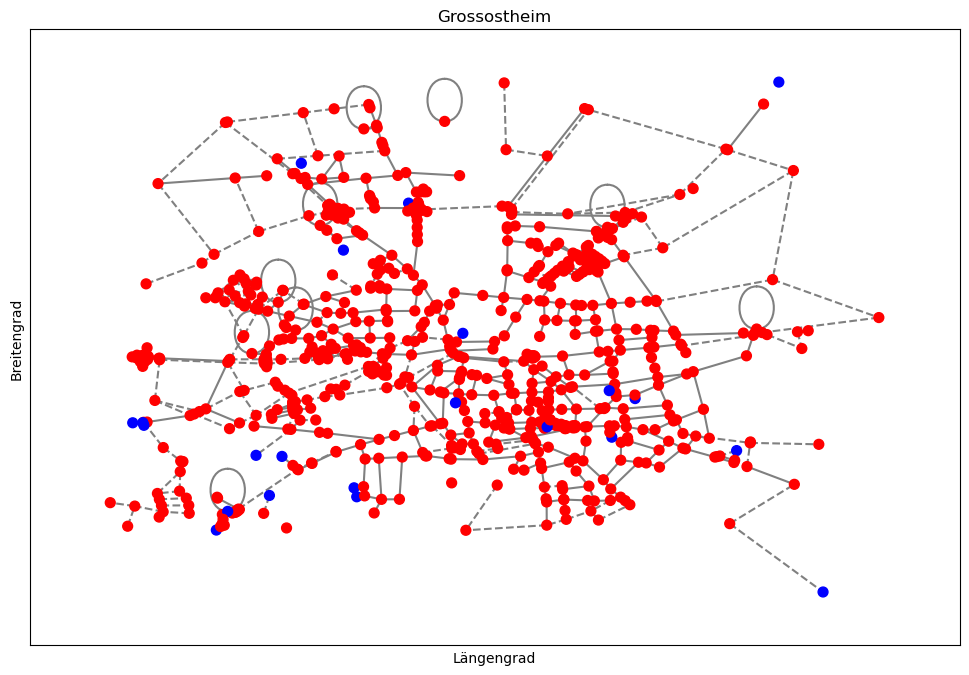

In [9]:
G = nx.Graph()

# Knoten zum Graphen hinzufügen
for index, row in filtered_data_multiple.iterrows():  
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

# Kanten zum Graphen hinzufügen
for index, way in ways_filter.iterrows():
    node_ids_list = way['node_ids']
    if node_ids_list is not None:
        filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
        if len(filtered_node_ids_list) > 1:
            for i in range(len(filtered_node_ids_list) - 1):
                is_dashed_highway = way['tagkey'] == 'highway' and way['tagvalue'] not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                G.add_edge(
                    filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                    street_name=way['tagvalue'],
                    is_dashed_highway=is_dashed_highway
                )

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(12, 8))

# Normale Kanten zeichnen
edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

# Gestrichelte Kanten zeichnen
edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

# Optional: Kantenbeschriftungen mit Straßennamen anzeigen
# edge_labels = nx.get_edge_attributes(G, 'street_name')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

plt.title(title)
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.show()

### Knoten zusammenfügen, die nah beieinander stehen

In [16]:
df_nodes = filtered_data_multiple[filtered_data_multiple['type'] == 'node']

# Alle Paare vom Knoten erstellen
node_pairs = []
node_ids = df_nodes['id'].tolist()
node_coords = list(zip(df_nodes['longitude'], df_nodes['latitude']))

# Berechnungen der Distanzen aller Knotenpaare und Speichern der Knotenpaare unter 10 Metern
for i, (lon1, lat1) in enumerate(node_coords):
    for j in range(i + 1, len(node_coords)):
        lon2, lat2 = node_coords[j]
        distance = haversine(lon1, lat1, lon2, lat2)
        if distance < 10:
            node_pairs.append((node_ids[i], node_ids[j]))

node_merge_dict = {}
new_nodes = []
# Für jedes Knotenpaar einen neuen Knoten erstellen
for node1_id, node2_id in node_pairs:
    node1 = df_nodes[df_nodes['id'] == node1_id].iloc[0]
    node2 = df_nodes[df_nodes['id'] == node2_id].iloc[0]

    # Berechnung der mittleren geografischen Position
    avg_lon = (node1['longitude'] + node2['longitude']) / 2
    avg_lat = (node1['latitude'] + node2['latitude']) / 2

    # Knoten-Id für Dictionary
    new_node_id = min(node1_id, node2_id)
    node_merge_dict[(node1_id, node2_id)] = new_node_id

    # Erstellen eines neuen Knotens
    new_nodes.append([node1_id, avg_lon, avg_lat])

df_new_nodes = pd.DataFrame(new_nodes, columns=['id', 'longitude', 'latitude']) 
df_new_nodes = df_new_nodes.drop_duplicates(subset=['id', 'longitude', 'latitude'])

filtered_data_multiple = pd.concat([filtered_data_multiple, df_new_nodes], ignore_index=True)

# Alten Knoten, die entfernt werden sollen
nodes_to_remove = set([node1_id for node1_id, _ in node_pairs] + [node2_id for _, node2_id in node_pairs])
filtered_data_multiple = filtered_data_multiple[filtered_data_multiple['id'].isin(nodes_to_remove) == False]

# Ersetzen der alten Knoten-Ids in node_ids durch den neuen Knoten
def update_node_ids(node_ids):
    if node_ids is not None and isinstance(node_ids, list):
        updated_node_ids = []
        for node_id in node_ids:
            # Ersetze Knoten-IDs durch den neuen zusammengefügten Knoten
            for (old_node1, old_node2), new_node_id in node_merge_dict.items():
                if node_id == old_node1 or node_id == old_node2:
                    updated_node_ids.append(new_node_id)
                    break
            else:
                updated_node_ids.append(node_id)
        return updated_node_ids
    return node_ids

filtered_data_multiple['node_ids'] = filtered_data_multiple['node_ids'].apply(update_node_ids)
filtered_data_multiple

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
0,way,7974876,True,15.0,highway,secondary,NaN,NaN,"[59648284, 6237482222, 3190521520]"
1,way,7974877,True,8.0,highway,residential,NaN,NaN,"[1395946813, 1536953569, 10676242033, 44496937..."
2,way,7974878,True,11.0,highway,residential,NaN,NaN,"[248048803, 59649381, 59649382, 59649383, 5964..."
3,way,22568421,True,11.0,highway,secondary,NaN,NaN,"[241929831, 6251639255, 279546515, 6251639256,..."
4,way,22568422,True,8.0,highway,secondary,NaN,NaN,"[241929831, 241929831, 6251639254, 6251639253,..."
...,...,...,...,...,...,...,...,...,...
1517,node,11166653705,True,0.0,None,None,9.064288,49.925452,None
1518,node,11176695330,True,0.0,None,None,9.068261,49.921862,None
1519,node,11414416159,True,0.0,None,None,9.068722,49.924349,None
1523,node,11486925682,True,0.0,None,None,9.077929,49.921546,None


### Graph nach Zusammenfügen der Knoten die beieinander stehen

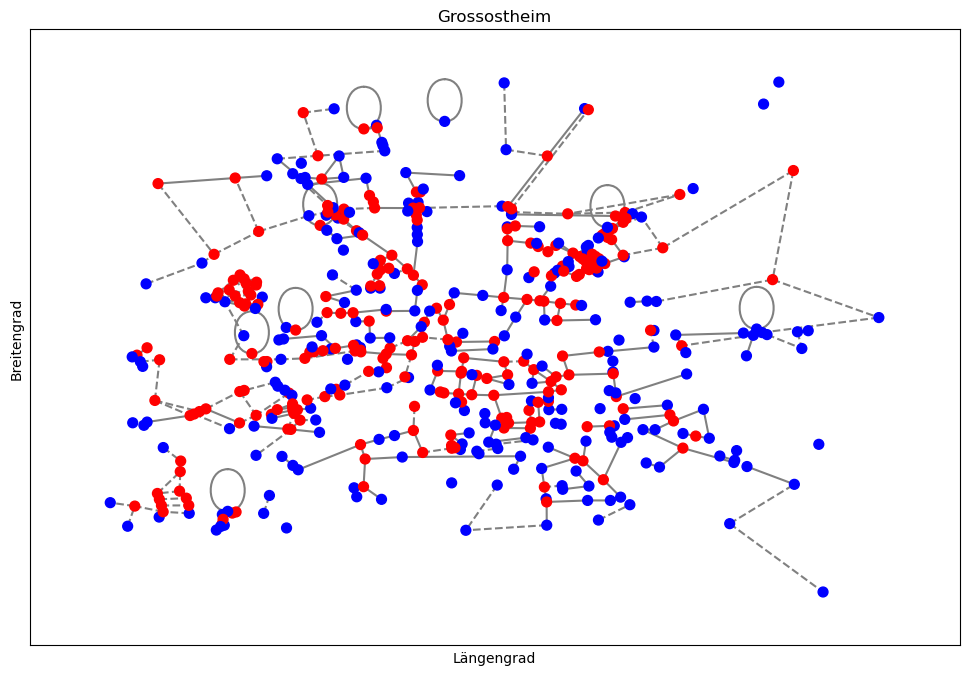

In [17]:
G = nx.Graph()

# Knoten zum Graphen hinzufügen
for index, row in filtered_data_multiple.iterrows():  
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

# Kanten zum Graphen hinzufügen
for index, way in ways_filter.iterrows():
    node_ids_list = way['node_ids']
    if node_ids_list is not None:
        filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
        if len(filtered_node_ids_list) > 1:
            for i in range(len(filtered_node_ids_list) - 1):
                is_dashed_highway = way['tagkey'] == 'highway' and way['tagvalue'] not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                G.add_edge(
                    filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                    street_name=way['tagvalue'],
                    is_dashed_highway=is_dashed_highway
                )

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(12, 8))

# Normale Kanten zeichnen
edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

# Gestrichelte Kanten zeichnen
edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

# Optional: Kantenbeschriftungen mit Straßennamen anzeigen
# edge_labels = nx.get_edge_attributes(G, 'street_name')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

plt.title(title)
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.show()

In [18]:
import plotly.graph_objects as go

node_degrees = dict(G.degree()) 

node_x = []
node_y = []
node_text = []  
node_color = [] 

for index, row in filtered_data_multiple.iterrows():
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        node_x.append(row['longitude'])
        node_y.append(row['latitude'])
        
        hover_info = f"ID: {row['id']}<br>Tag Key: {row['tagkey']}<br>Tag Value: {row['tagvalue']}<br>Degree: {node_degrees[row['id']]}"
        node_text.append(hover_info)
        
        node_color.append(node_degrees[row['id']])

edge_x = []
edge_y = []
dashed_edge_x = []
dashed_edge_y = []
edge_street_names = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]

    # Überprüfen, ob der Rand highway != 'residual' ist
    is_dashed_highway = False
    street_name = ""
    for street in ways_filter.itertuples():
        if edge[0] in street.node_ids and edge[1] in street.node_ids:
            street_name = street.tagvalue
            # Highway-Kanten, die nicht 'residual' sind, werden gestrichelt
            if street.tagkey == "highway" and street.tagvalue not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']:
                is_dashed_highway = True
            break

    if is_dashed_highway:
        dashed_edge_x.extend([x0, x1, None])
        dashed_edge_y.extend([y0, y1, None])
    else:
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Berechnung der Mittelpunkte für die Straßennamen
    midpoint_x = (x0 + x1) / 2
    midpoint_y = (y0 + y1) / 2
    edge_street_names.append((midpoint_x, midpoint_y, street_name))


# Plot für durchgezogene Kanten
solid_edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Plot für gestrichelte Kanten (highways)
dashed_edge_trace = go.Scatter(
    x=dashed_edge_x, y=dashed_edge_y,
    line=dict(width=0.5, color='#888', dash='dash'),
    hoverinfo='none',
    mode='lines'
)

# Plot für Knoten
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Knoten Verbindungen',
            xanchor='left',
            titleside='right'
        )),
    text=node_text
)

# Hinzufügen der Straßennamen zwischen den Knoten
street_name_trace = go.Scatter(
    x=[name[0] for name in edge_street_names],
    y=[name[1] for name in edge_street_names],
    text=[name[2] for name in edge_street_names],
    mode='text',
    textfont=dict(
        size=12,
        color='darkblue'
    ),
    hoverinfo='text'
)

layout = go.Layout(
    title='Großostheim',
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=0),
    annotations=[dict(
        text=title,
        showarrow=False,
        xref="paper", yref="paper",
        x=0.005, y=-0.002)],
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False)
)

fig = go.Figure(data=[solid_edge_trace, dashed_edge_trace, node_trace], layout=layout)

fig.show()


### Diagramm um den Grad der Knoten

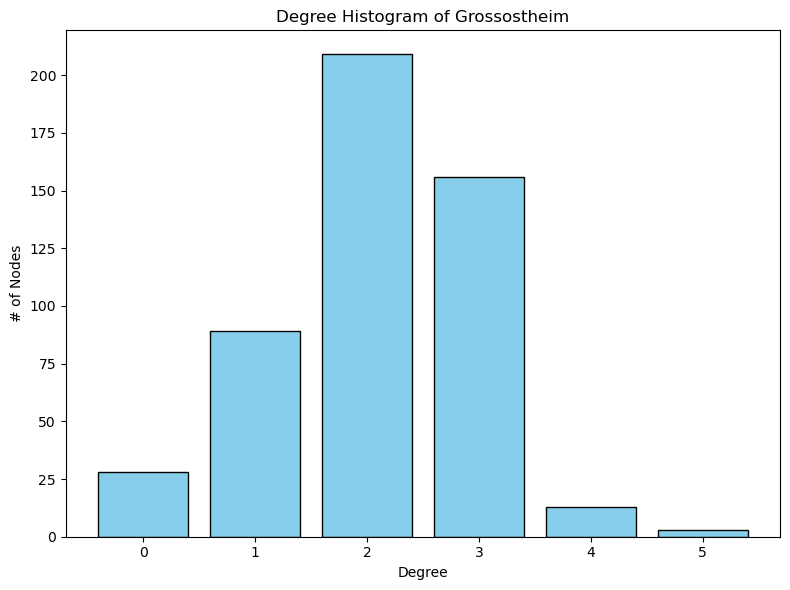

In [ ]:
from matplotlib.ticker import MaxNLocator

degrees = list(node_degrees.values())
degree_sequence = sorted(degrees, reverse=True)

unique_degrees, counts = np.unique(degrees, return_counts=True)

fig = plt.figure(figsize=(8, 6))

plt.bar(unique_degrees, counts, color='skyblue', edgecolor='black')
plt.title("Degree Histogram of" + " " + title)
plt.xlabel("Degree")
plt.ylabel("# of Nodes")

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()

plt.show()

### Diagramm um die Länge der Straßen

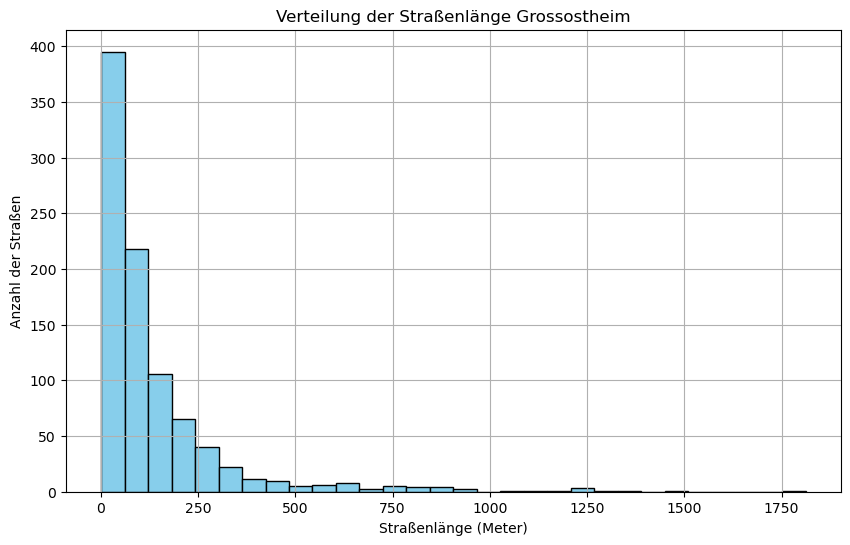

In [23]:
# Erstelle das Histogramm
plt.figure(figsize=(10, 6))
plt.hist(df_road_length['length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Verteilung der Straßenlänge'  + " " + title)
plt.xlabel('Straßenlänge (Meter)')
plt.ylabel('Anzahl der Straßen')
plt.grid(True)
plt.show()

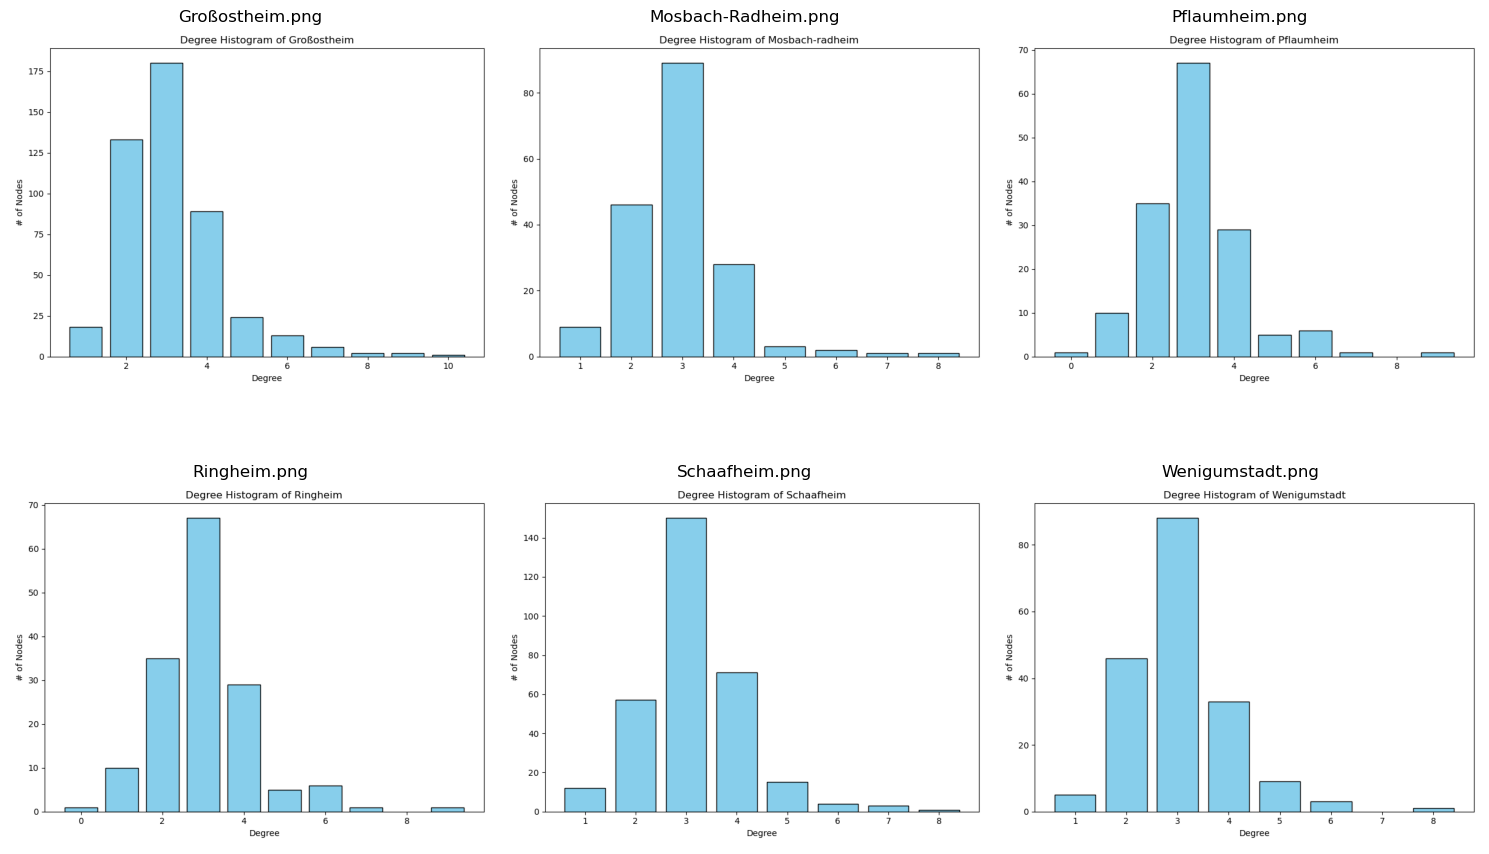

In [20]:
# Plot with Degree Diagrams
image_folder = 'Degree of various places'
images = [file for file in os.listdir(image_folder) if file.endswith(('png'))]

# Number of images
num_images = len(images)

cols = 3
rows = num_images // cols + (num_images % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i, img_name in enumerate(images):
    img_path = os.path.join(image_folder, img_name)
    img = mpimg.imread(img_path)

    ax = axs[i // cols, i % cols] if rows > 1 else axs[i % cols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_name)

for j in range(i + 1, rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [ ]:
# Plot with length Diagrams
image_folder = 'Street length of various places'
images = [file for file in os.listdir(image_folder) if file.endswith(('png'))]

# Number of images
num_images = len(images)

cols = 3
rows = num_images // cols + (num_images % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i, img_name in enumerate(images):
    img_path = os.path.join(image_folder, img_name)
    img = mpimg.imread(img_path)

    ax = axs[i // cols, i % cols] if rows > 1 else axs[i % cols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_name)

for j in range(i + 1, rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

# Deprecated

In [ ]:
# Knoten in Cluster zusammenfassen
coords = df_nodes_filtered_multiple[['longitude', 'latitude']].values
eps_distance = 0.0004
clustering = DBSCAN(eps=eps_distance, min_samples=1).fit(coords)

# Cluster-Labels zuweisen
df_nodes_filtered_multiple['cluster'] = clustering.labels_

# Cluster-Vertreter bestimmen
cluster_representatives = df_nodes_filtered_multiple.groupby('cluster')['id'].min().to_dict()

# Ersetzungs-Dictionary für alle Knoten -> Cluster-Vertreter
node_to_representative = {}
for node_id, cluster in df_nodes_filtered_multiple[['id', 'cluster']].values:
    if cluster in cluster_representatives:
        node_to_representative[node_id] = cluster_representatives[cluster]

print(f"node_to_representative für ID 6251639256: {node_to_representative.get(6251639256)}")

def replaces_node_ids(node_ids):
    if node_ids is None:
        return None
    # Knoten-Id in node_ids durch zugehörige Cluster-Vetreter-Id ersetzen
    replaced_node_ids = [node_to_representative.get(node_id, node_id) for node_id in node_ids]
    print(f"Original: {node_ids} -> Ersetzt: {replaced_node_ids}") 
    return replaced_node_ids

ways_filter['node_ids'] = ways_filter['node_ids'].apply(replaces_node_ids)

ways_filter['node_ids'] = ways_filter['node_ids'].apply(lambda x: list(dict.fromkeys(x)))

df_cluster_nodes = df_nodes_filtered_multiple[df_nodes_filtered_multiple['id'].isin(cluster_representatives.values())]
df_cluster_nodes = df_cluster_nodes.drop(columns='cluster')

filtered_data_combined = pd.concat([ways_filter, df_cluster_nodes], ignore_index=True)
filtered_data_combined

In [ ]:

# Funktion zur Berechnung der Straßenlänge basierend auf den referenzierten Knoten
def calculate_road_length(way_row, df_nodes):
    first_node_id = way_row['node_ids'][0]
    last_node_id = way_row['node_ids'][-1]

    # Überprüfe, ob der erste Knoten im DataFrame existiert
    first_node = df_nodes[df_nodes['id'] == first_node_id]
    if first_node.empty:
        print(f"Warnung: Erster Knoten mit ID {first_node_id} nicht gefunden!")
        return 0 

    # Überprüfe, ob der letzte Knoten im DataFrame existiert
    last_node = df_nodes[df_nodes['id'] == last_node_id]
    if last_node.empty:
        print(f"Warnung: Letzter Knoten mit ID {last_node_id} nicht gefunden!")
        return 0 

    # Berechne die Entfernung zwischen den Knoten
    length = haversine(first_node['longitude'].values[0], first_node['latitude'].values[0],
                       last_node['longitude'].values[0], last_node['latitude'].values[0])
    return length

filtered_data_combined['road_length'] = filtered_data_combined[filtered_data_combined['type'] == 'way'].apply(calculate_road_length, axis=1, df_nodes=df_cluster_nodes)
filtered_data_combined